# Fit Batch Survival Model

This notebook fits a linear logit model to bacterial survival data as a function of RHL and HQNO concentrations. 

In [61]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from matplotlib.colors import to_rgb

# — user parameters —
data_path = Path.cwd().parent / 'datafiles' / 'HQNO_RHL_Survival.csv'



# — transforms —
def logit(p, eps=1e-6):
    """ Logit transform with clipping to avoid inf values.
    Args:
        p (array-like): probabilities in [0, 1]
        eps (float): small value to clip probabilities
    Returns:
        array-like: logit-transformed values
    """
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def inv_logit(z):
    """ Inverse logit transform.
    Args:
        z (array-like): logit values
    Returns:
        array-like: probabilities in [0, 1]
    """
    return 1 / (1 + np.exp(-z))

# — model: linear in RHL and HQNO —
def model_linear(X, m_rhl, m_hqno, b):
    """
    Linear logit model: logit(Survival) = m_rhl*RHL + m_hqno*HQNO + b
    
    Args:
        X (array-like): 2D array with shape (2, N) where first row is RHL and second row is HQNO
        m_rhl (float): slope for RHL
        m_hqno (float): slope for HQNO
        b (float): intercept
    Returns:
        array-like: logit-transformed survival values
    """
    rhl, hqno = X
    return m_rhl * rhl + m_hqno * hqno + b

def fit_model(df):
    """ Fit linear logit model to data.
    Args:
        df (pd.DataFrame): DataFrame with columns "Rhamnolipids (µg/ml)", "HQNO (µg/ml)", "Survival
        Returns:
        params (tuple): Fitted parameters (m_rhl, m_hqno, b)
    """

    # — prepare data arrays —
    rhl_vals  = df["Rhamnolipids (µg/ml)"].values
    hqno_vals = df["HQNO (µg/ml)"].values
    surv_vals = df["Survival"].values
    y_logit   = logit(surv_vals)

    # — fit linear model —
    X = np.vstack((rhl_vals, hqno_vals))
    p0 = [0.0, 0.0, np.median(y_logit)]  # [m_rhl, m_hqno, b]
    params, _ = curve_fit(model_linear, X, y_logit, p0=p0)
    m_rhl, m_hqno, b = params
    print(f"Fitted params: m_rhl={m_rhl:.4f}, m_hqno={m_hqno:.4f}, b={b:.4f}")

    params_out = {
        "model": "Linear-in-RHL-and-HQNO Logit",
        "parameters": {
            "m_rhl": float(m_rhl),
            "m_hqno": float(m_hqno),
            "b":  float(b),
        }       
    }
    return params_out

def create_rhl_colors(n_levels):
    """Create purple gradient from light to dark based on #cc99ff.
    Lower RHL = lighter, higher RHL = darker"""
    base_color = np.array(to_rgb('#cc99ff'))
    colors = []
    for i in range(n_levels):
        # Start light (high factor) and go darker (low factor)
        # Reverse the progression: first level is lightest, last is darkest
        factor = 1.0 - 0.6 * (i / max(n_levels - 1, 1))
        color = base_color * factor
        colors.append(color)
    return colors

Fitted params: m_rhl=-0.4266, m_hqno=207.0848, b=-7.3829
Saved parameters to ./data/survival_model_parameters.json
Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.
Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.


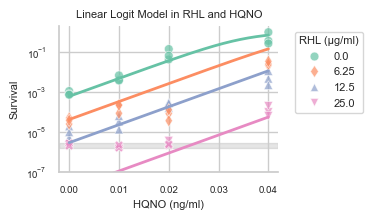

In [72]:
# — load & filter —
df = pd.read_csv(data_path)

filters = {
            "timepoint_h": 2,
            "hqno_max": 0.05,
        }

# add fractional survival
df_t0 = df[df['Timepoint (h)'] == 0][['Rhamnolipids (µg/ml)', 'HQNO (µg/ml)', 'Replicate', 'CFU']].copy()
df_t0 = df_t0.rename(columns={'CFU': 'CFU_t0'})
df_all = df.merge(df_t0, on=['Rhamnolipids (µg/ml)', 'HQNO (µg/ml)', 'Replicate'], how='left')
df_all['Survival'] = df_all['CFU'] / df_all['CFU_t0']

# add limit of detection
df_all['survival_lod'] = 200 / df_all['CFU_t0']
df_all = df_all.drop(columns=['CFU_t0'])

# filter to 2h timepoint and HQNO < 0.05 µg/ml
df = df_all[df_all["Timepoint (h)"] == filters["timepoint_h"]].copy()
df = df[df["HQNO (µg/ml)"] < filters["hqno_max"]]
df['below_lod'] = df['Survival'] < df['survival_lod']

# filter out below LOD
df_below_lod = df[df['below_lod']] # store for reference
df = df[~df['below_lod']] 

# growth can occur during early phase of AB treatment, leading to survival > 1
# we will handle this by normalizing such that max survival is 1
df["Survival"] /= df["Survival"].max()

# — fit model —
params_out = fit_model(df)

# — save parameters to JSON —
params_out['filters'] = filters
json_path = "./data/survival_model_parameters.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(params_out, f, indent=2)

print(f"Saved parameters to {json_path}")
    
# — visualize fit —
# ——— figure style ———
final_width_in = 10 / 2.54
final_height_in = 6 / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

num_rhl_levels = len(df["Rhamnolipids (µg/ml)"].unique())
rhl_levels = np.sort(df["Rhamnolipids (µg/ml)"].unique())


sns.set_theme(style="whitegrid")
#colors = create_rhl_colors(num_rhl_levels)
colors = sns.color_palette("Set2", n_colors=num_rhl_levels)
symbols = ['o', 'd', '^', 'v']

plt.figure(figsize=(final_width_in, final_height_in))
ax = sns.scatterplot(
    x="HQNO (µg/ml)", y="Survival",
    hue="Rhamnolipids (µg/ml)", hue_order=rhl_levels,
    palette=colors, data=df, s=40, alpha=0.7, 
    style="Rhamnolipids (µg/ml)", markers=symbols, style_order=rhl_levels
)

ax = sns.scatterplot(
    x="HQNO (µg/ml)", y="survival_lod",
    hue="Rhamnolipids (µg/ml)", hue_order=rhl_levels,
    palette=colors, data=df_below_lod, s=40, alpha=0.7, marker='X', legend=False
)

min_lod = df_below_lod['survival_lod'].min()
max_lod = df_below_lod['survival_lod'].max()
ax.axhspan(min_lod, max_lod, alpha=0.2, color='grey', zorder=0)


hqno_grid = np.linspace(df["HQNO (µg/ml)"].min(), df["HQNO (µg/ml)"].max(), 200)

m_rhl = params_out["parameters"]["m_rhl"]
m_hqno = params_out["parameters"]["m_hqno"]
b     = params_out["parameters"]["b"]

for lvl, col in zip(rhl_levels, colors):
    z = model_linear(
        (np.full_like(hqno_grid, lvl), hqno_grid),
        **params_out["parameters"]
    )
    plt.plot(hqno_grid, inv_logit(z), color=col, lw=2)

ax.set_title("Linear Logit Model in RHL and HQNO", fontsize=font_size)
ax.set_xlabel("HQNO (ng/ml)", fontsize=font_size)
ax.set_ylabel("Survival", fontsize=font_size)

ax.tick_params(axis='both', which='major', labelsize=font_size -1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(title="RHL (µg/ml)", bbox_to_anchor=(1.05,1), loc='upper left', fontsize=font_size, title_fontsize=font_size)
plt.yscale("log")
plt.tight_layout()
plt.savefig("./figures/logit_fit_survival_data.pdf", dpi=300, transparent=True)
plt.ylim(1e-7, 2)

print("Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.")

plt.show()

